In [1]:
!pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 728.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib
      creating build/lib/fbprophet
      creating build/lib/fbprophet/stan_model
      Traceback (most recent call last):
        File "<string>", line 36, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-zw6w8ukm/fbprophet_863bd3692b3f4dca86

In [2]:

#Data Pre-Processing packages:
import numpy as np 
import pandas as pd 
from datetime import datetime


#Data Visualization Packages:
#Seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

#Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

#Colorama
from colorama import Fore, Back, Style # For text colors
y_= Fore.CYAN
m_= Fore.WHITE

#garbage collector - To free up unused space
import gc
gc.collect()

#NetworkX
import networkx as nx
import plotly.graph_objects as go #To construct network graphs

#To avoid printing of un necessary Deprecation warning and future warnings!
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

#Time series Analysis pacakages:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Facebook Prophet packages:


#from fbprophet import Prophet
#from fbprophet.diagnostics import cross_validation, performance_metrics
#from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

#Time -To find how long each cell takes to run
import time

#Importing of Data 
data=pd.read_csv('../input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')



In [3]:

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric


In [4]:
print(f"{m_}Total records:{y_}{data.shape}\n")
print(f"{m_}Data types of data columns: \n{y_}{data.dtypes}")

Total records:(4857377, 8)

Data types of data columns: 
Timestamp              int64
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtype: object


<div class="alert alert-info">
    <h3 color:black><center><b> Data Pre-processing steps</b></center></h3>
    <p> 1. <b>Date</b> - We need to convert the Hourly data to Daily based data </p>
    <p> 2. <b>Fill in the missing values interpolation</p>

</div>

<div class='alert alert-info'>
<h3> The data is available on a Hourly based on each day, So we need to resample them to day based.</h3>
</div>

In [5]:
data['Timestamp'] = [datetime.fromtimestamp(x) for x in data['Timestamp']]
data = data.set_index('Timestamp')
data = data.resample("24H").mean()
data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


<div class="alert alert-info">
    <h3><b><center>Missing values</center><b></h3>
</div>


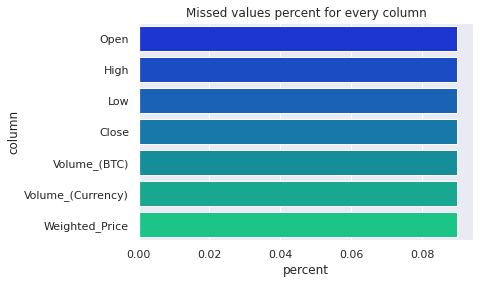

In [6]:
missed = pd.DataFrame()
missed['column'] = data.columns

missed['percent'] = [round(100* data[col].isnull().sum() / len(data), 2) for col in data.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]

fig = sns.barplot(
    x=missed['percent'], 
    y=missed["column"], 
    orientation='horizontal',palette="winter"
).set_title('Missed values percent for every column')

<div class="alert alert-info">
    <h3><b><center>Let's interpolate to fill in the missing values</center><b></h3>
</div>


In [7]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    print(f'{m_}No. of Missing values after interpolation:\n{y_}{df.isnull().sum()}')
    
fill_missing(data)

No. of Missing values after interpolation:
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


<a id="3"></a>
<h2 style='background-color:#87CEFA; border:0; color:black'><center>Feature Generation</center><h2>

In [8]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price'],
      dtype='object')

In [9]:
new_df=data.groupby('Timestamp').mean()
new_df=new_df[['Volume_(BTC)', 'Close','Volume_(Currency)']]
new_df.rename(columns={'Volume_(BTC)':'Volume_market_mean','Close':'close_mean','Volume_(Currency)':'volume_curr_mean'},inplace=True)
new_df.head()

,Volume_market_mean,close_mean,volume_curr_mean
Timestamp,,,
2011-12-31,23.829470,4.482500,106.330084
2012-01-01,7.200667,4.806667,35.259720
2012-01-02,19.048000,5.000000,95.240000
2012-01-03,11.004660,5.252500,58.100651
2012-01-04,11.914807,5.223333,63.119577


In [10]:
data_df = data.merge(new_df, left_on='Timestamp',
                                right_index=True)
data_df['volume(BTC)/Volume_market_mean'] = data_df['Volume_(BTC)'] / data_df['Volume_market_mean']
data_df['Volume_(Currency)/volume_curr_mean'] = data_df['Volume_(Currency)'] / data_df['volume_curr_mean']

data_df['close/close_market_mean'] = data_df['Close'] / data_df['close_mean']
data_df['open/close'] = data_df['Open'] / data_df['Close']
data_df["gap"] = data_df["High"] - data_df["Low"] 
data_df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Volume_market_mean,close_mean,volume_curr_mean,volume(BTC)/Volume_market_mean,Volume_(Currency)/volume_curr_mean,close/close_market_mean,open/close,gap
Timestamp,,,,,,,,,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603,23.829470,4.482500,106.330084,1.0,1.0,1.0,0.996096,0.017500
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667,7.200667,4.806667,35.259720,1.0,1.0,1.0,1.000000,0.000000
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000,19.048000,5.000000,95.240000,1.0,1.0,1.0,1.000000,0.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500,11.004660,5.252500,58.100651,1.0,1.0,1.0,1.000000,0.000000
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159,11.914807,5.223333,63.119577,1.0,1.0,1.0,0.995533,0.023333


<div class='alert alert-info'>
     <p> Sometimes, the data set might be too huge to process, since we are using dataframe. To make sure we dont hold up too much RAM. We could try other approaches like</p>
     <p> 1. use gc.collect() - collects all the garbage values </p>
     <p> 2. del dataframe - free up some space by deleting the unused dataframe using the del command </p>
     <p> 3. Reduce the memory usage based on the data types of the columns in the dataframe(shown below)</p>
</div>

In [11]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)
print(f'{m_}Memory of the dataframe:\n{y_}{mem_usage(data_df)}')

Memory of the dataframe:
0.41 MB


In [12]:
#All the columns in float64 format, we can downsize them to float32 to reduce memory usage 
data_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3379 entries, 2011-12-31 to 2021-03-31
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Open                                3379 non-null   float64
 1   High                                3379 non-null   float64
 2   Low                                 3379 non-null   float64
 3   Close                               3379 non-null   float64
 4   Volume_(BTC)                        3379 non-null   float64
 5   Volume_(Currency)                   3379 non-null   float64
 6   Weighted_Price                      3379 non-null   float64
 7   Volume_market_mean                  3379 non-null   float64
 8   close_mean                          3379 non-null   float64
 9   volume_curr_mean                    3379 non-null   float64
 10  volume(BTC)/Volume_market_mean      3379 non-null   float64
 11  Volume_(Currency)/volume_

<div class='alert alert-info'>
<h3>We can use the function pd.to_numeric() to downcast our float types. We’ll use DataFrame.select_dtypes to select only the float columns, then we’ll optimize the types and compare the memory usage.</h3>
</div>

In [13]:
gl_float = data_df.select_dtypes(include=['float'])
converted_float = gl_float.apply(pd.to_numeric,downcast='float')
compare_floats = pd.concat([gl_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['Before','After']
compare_floats.apply(pd.Series.value_counts)

,Before,After
float32,NaN,15.0
float64,15.0,NaN


In [14]:
print(f"{m_}Before float conversion:\n{y_}{mem_usage(data_df)}")
data_df[converted_float.columns] = converted_float
print(f"{m_}After float conversion:\n{y_}{mem_usage(data_df)}")

Before float conversion:
0.41 MB
After float conversion:
0.22 MB


<div class='alert alert-info'>
    <h3>We have successfully reduced the size of the dataframe by 50%. Eventhough, the size of the dataframe used here is small in this analysis. It's always a good aprroach to reduce the memory usage</h3>
</div>

<a id="4"></a>
<h2 style='background-color:#87CEFA; border:0; color:black'><center>Distribution of Features</center><h2>

<div class="alert alert-info">
    <h3><b>Let's Visualize the distribution of the key variables like Opening price, Highest price, Lowest price and Volume in Bitcoin<b></h3>
</div>


In [15]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(25,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

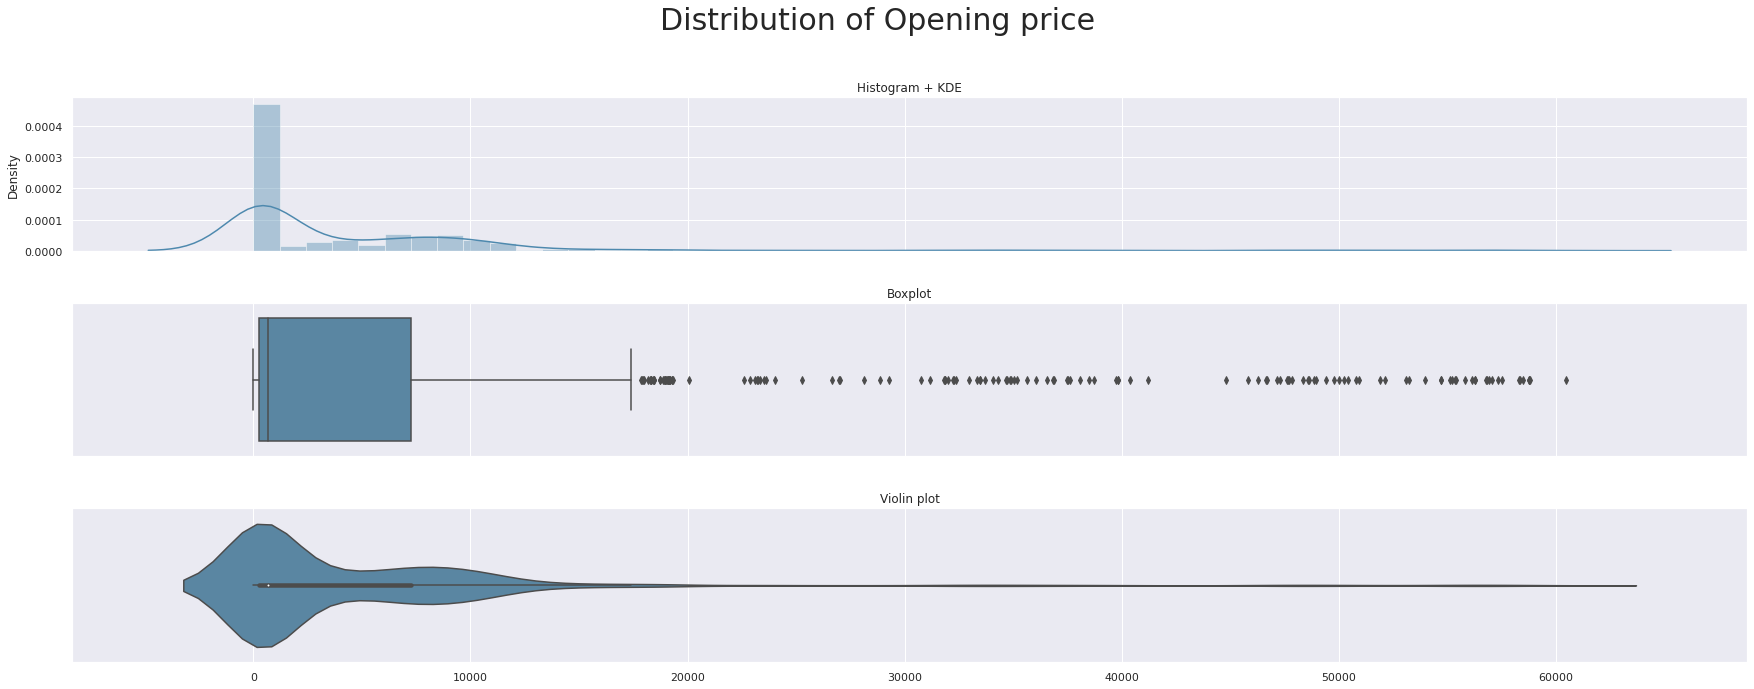

In [16]:
triple_plot(data['Open'],'Distribution of Opening price',custom_colors[0])

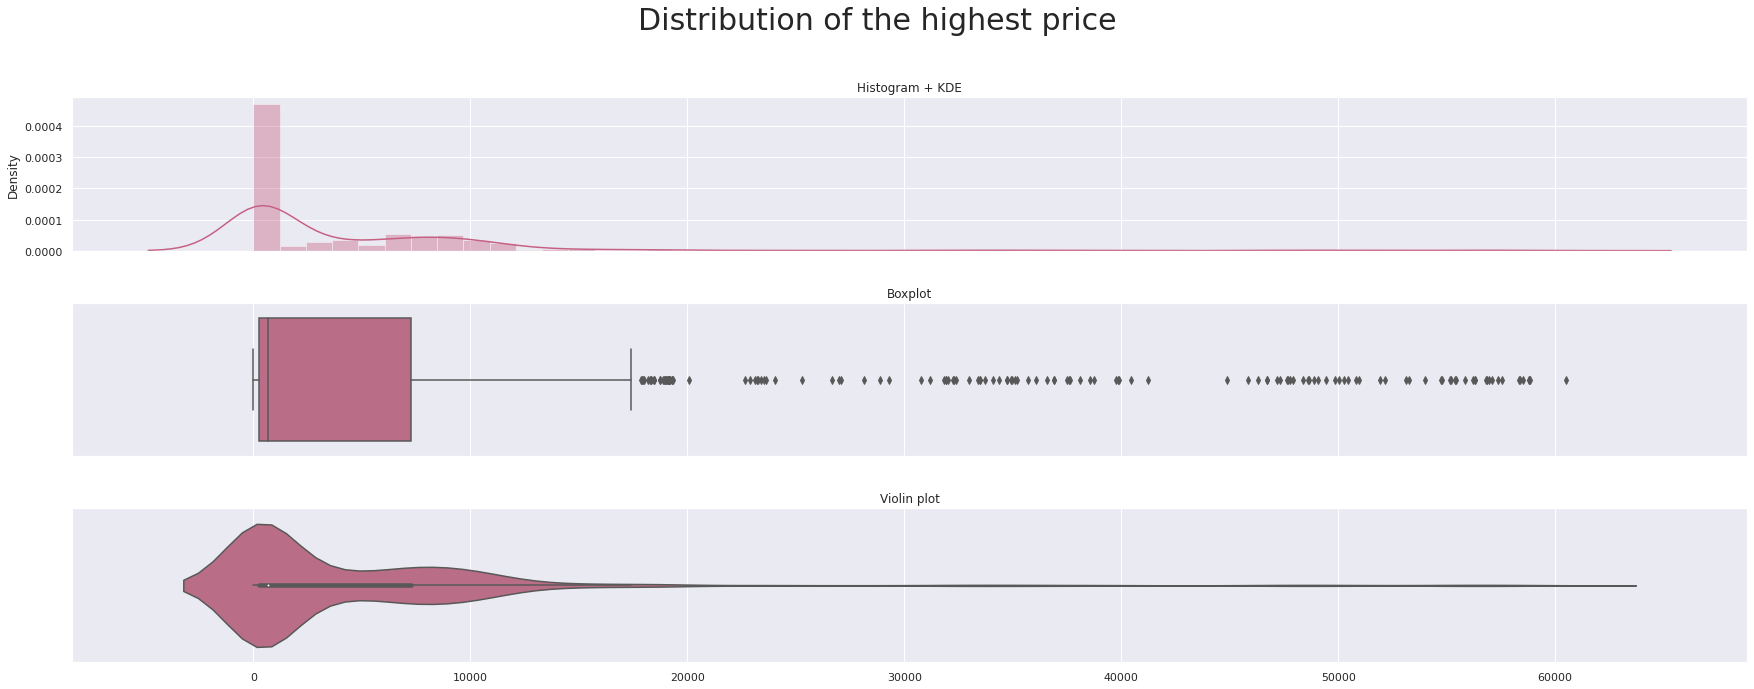

In [17]:
triple_plot(data['High'],'Distribution of the highest price',custom_colors[1])

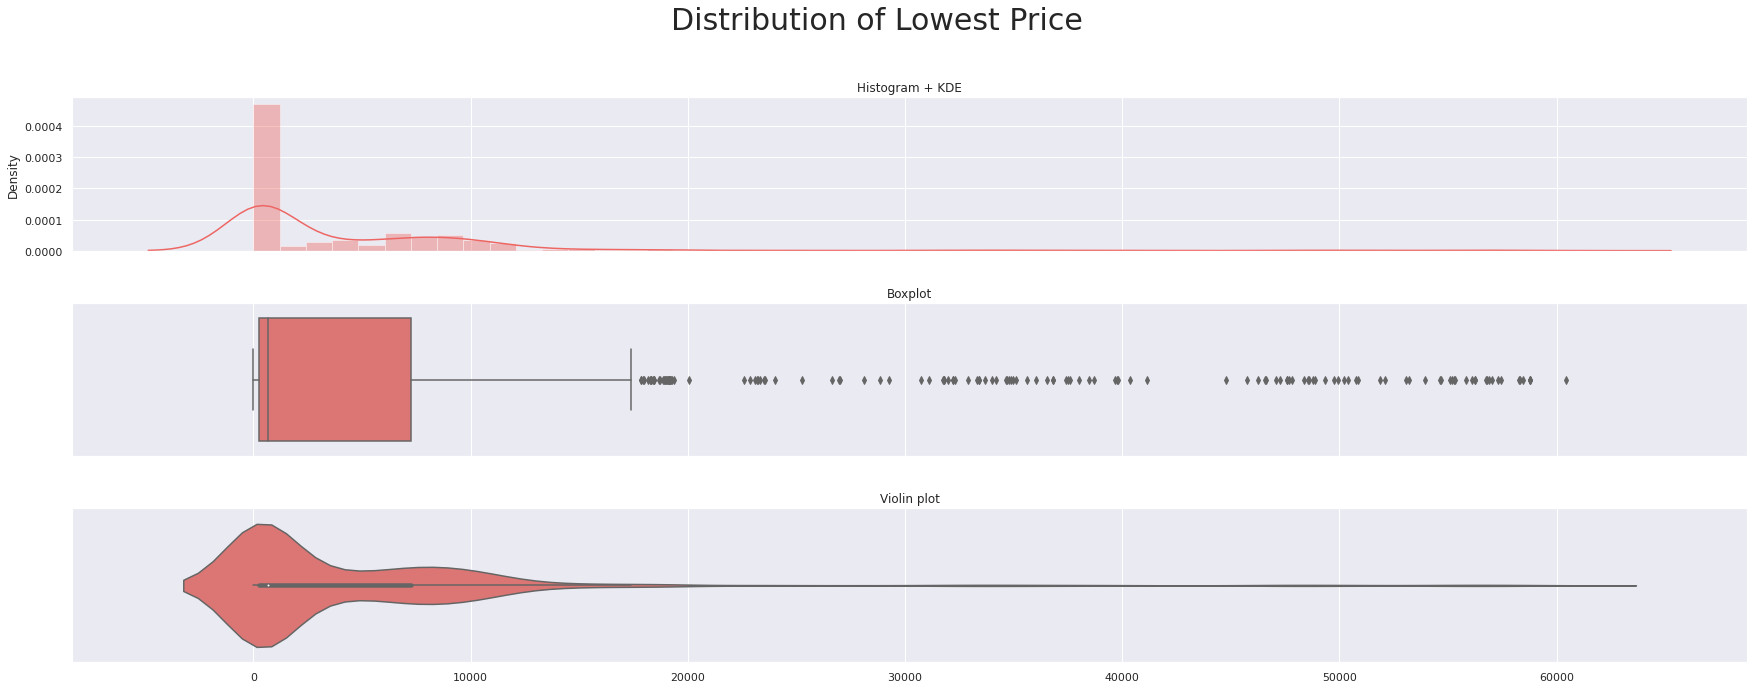

In [18]:
triple_plot(data['Low'],'Distribution of Lowest Price',custom_colors[2])

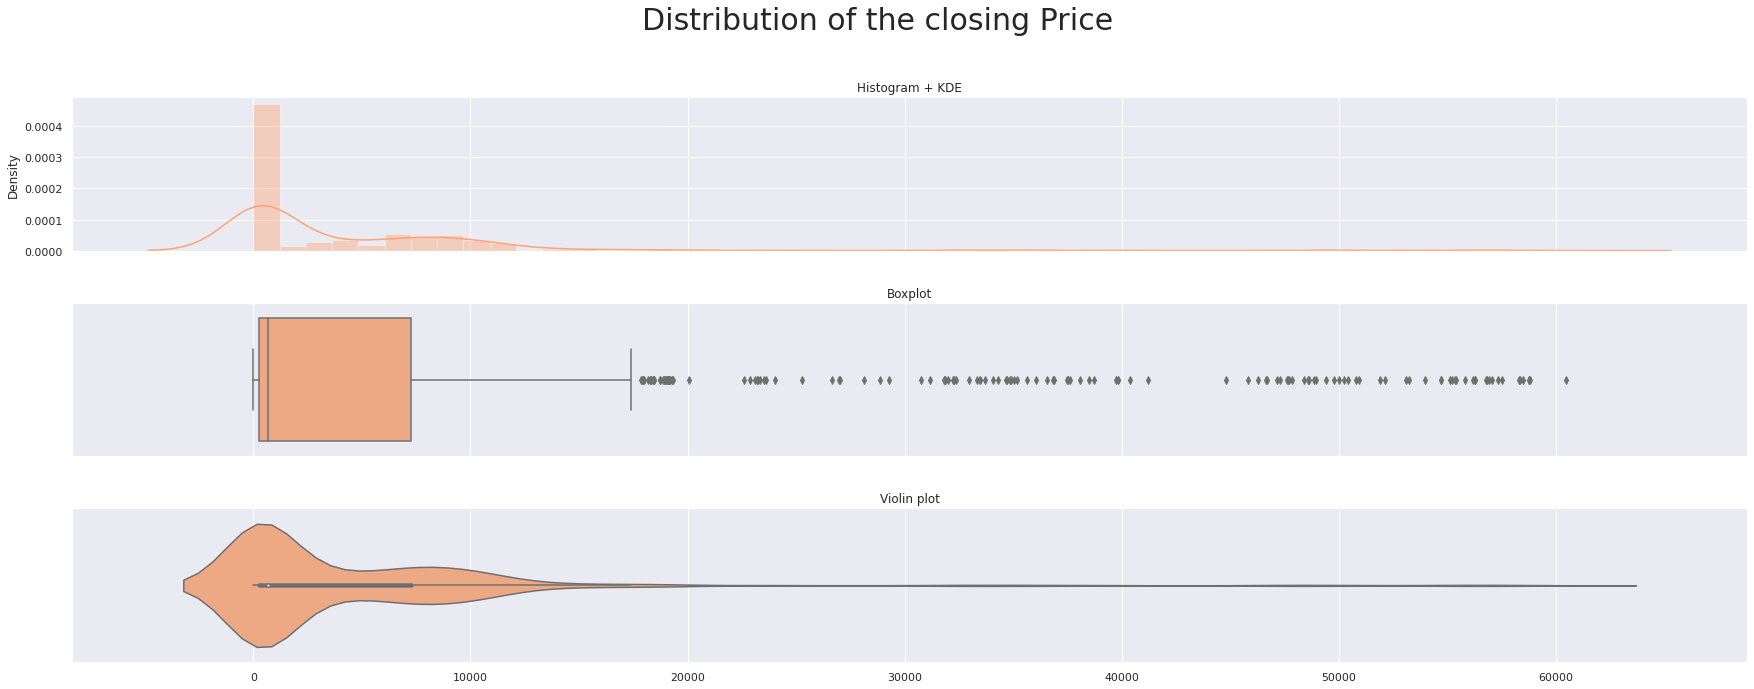

In [19]:
triple_plot(data['Close'],'Distribution of the closing Price',custom_colors[3])

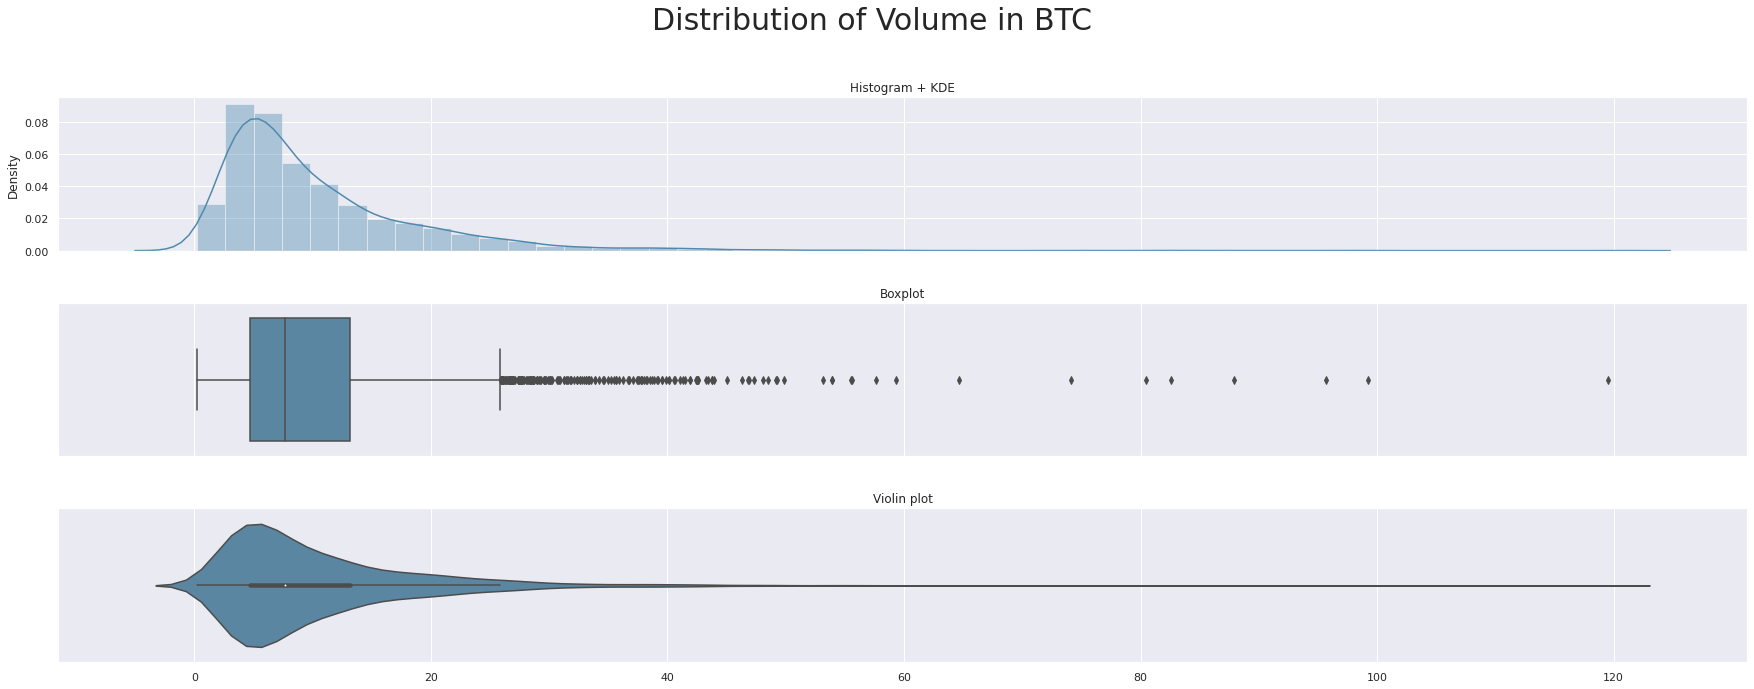

In [20]:
triple_plot(data['Volume_(BTC)'],'Distribution of Volume in BTC ',custom_colors[0])

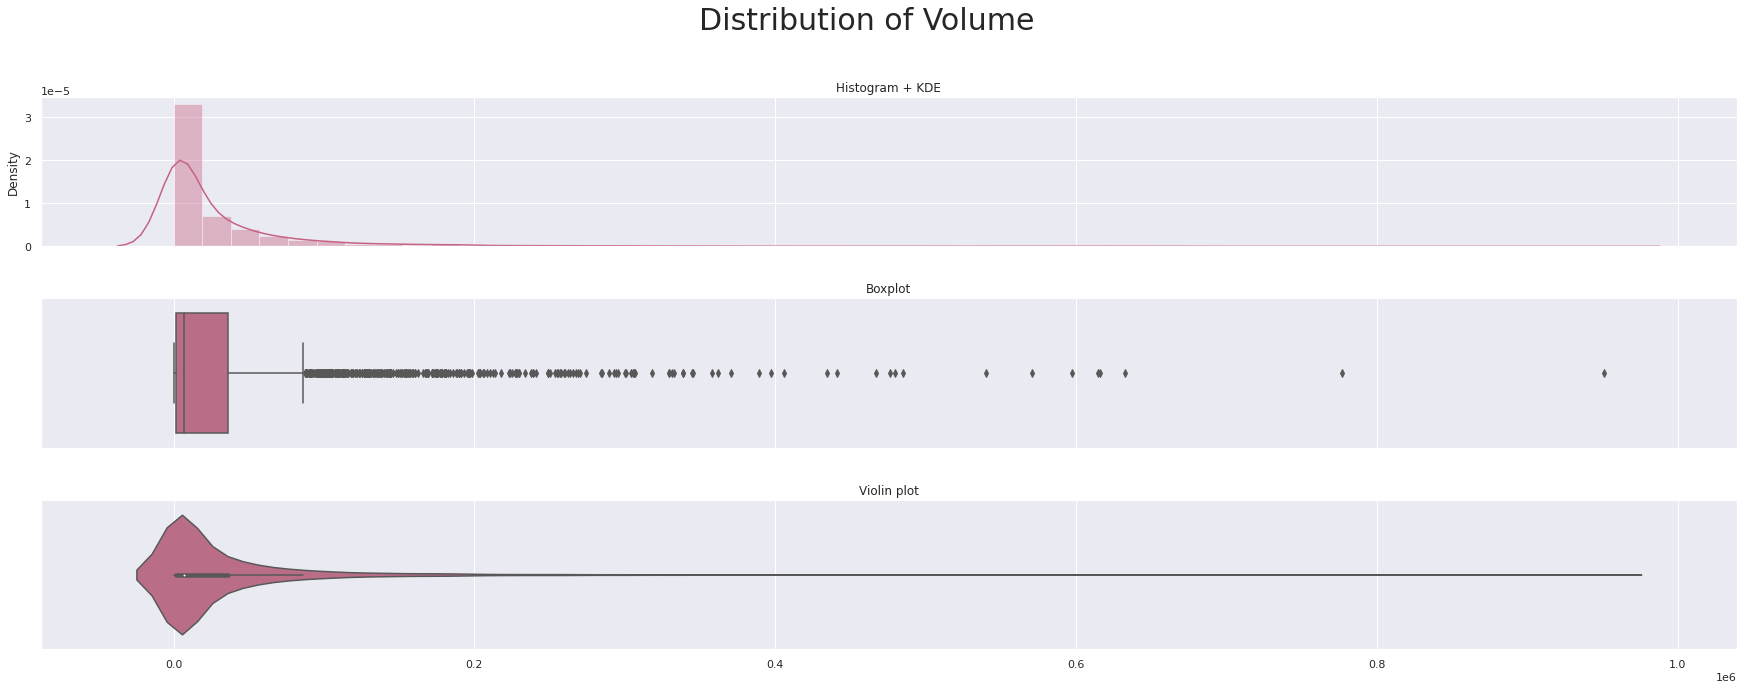

In [21]:
triple_plot(data['Volume_(Currency)'],'Distribution of Volume',custom_colors[1])

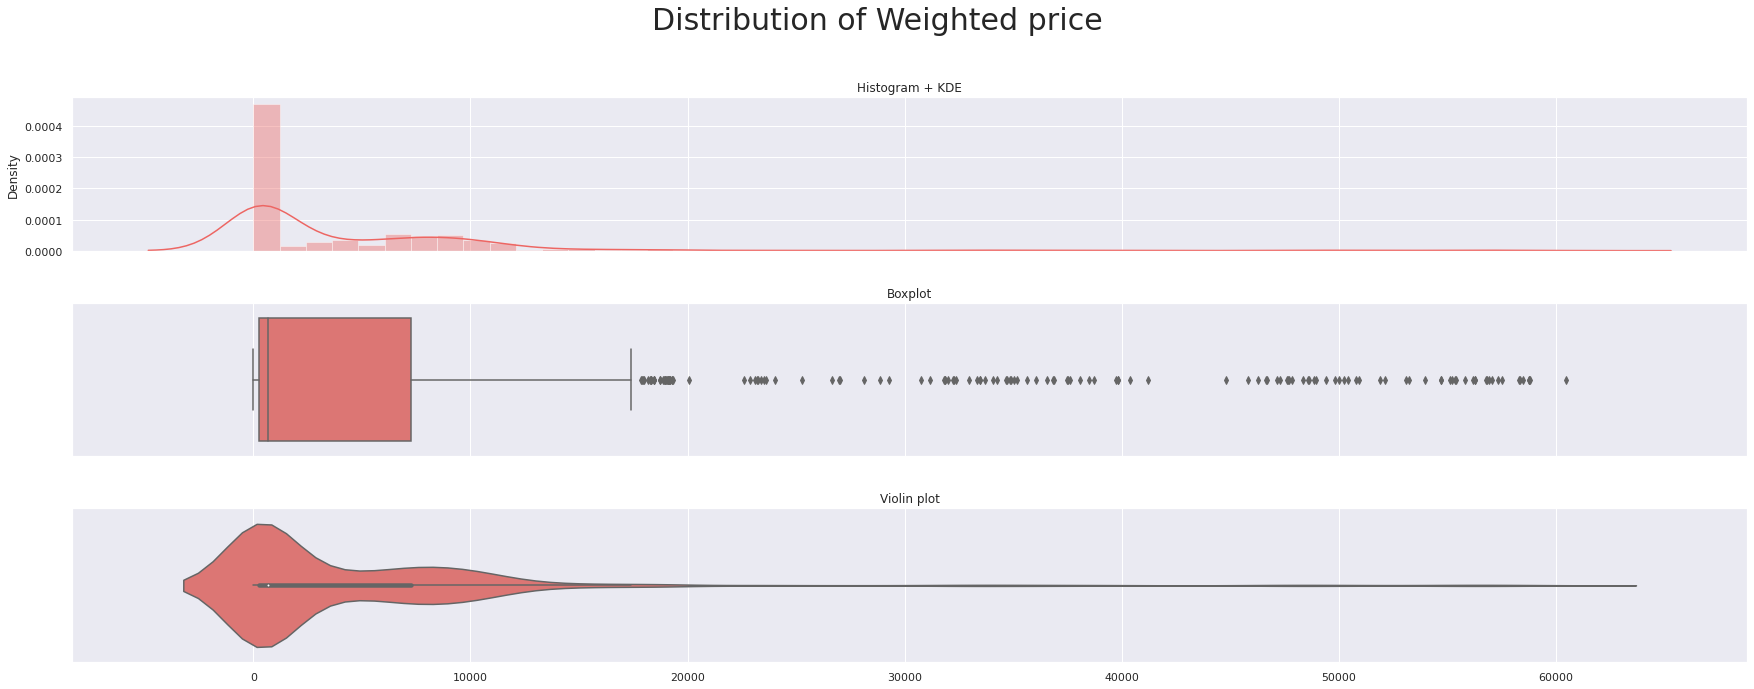

In [22]:
triple_plot(data['Weighted_Price'],'Distribution of Weighted price',custom_colors[2])

<a id="5"></a>
<h2 style='background-color:#87CEFA; border:0; color:black'><center>Correlation Analysis</center><h2>

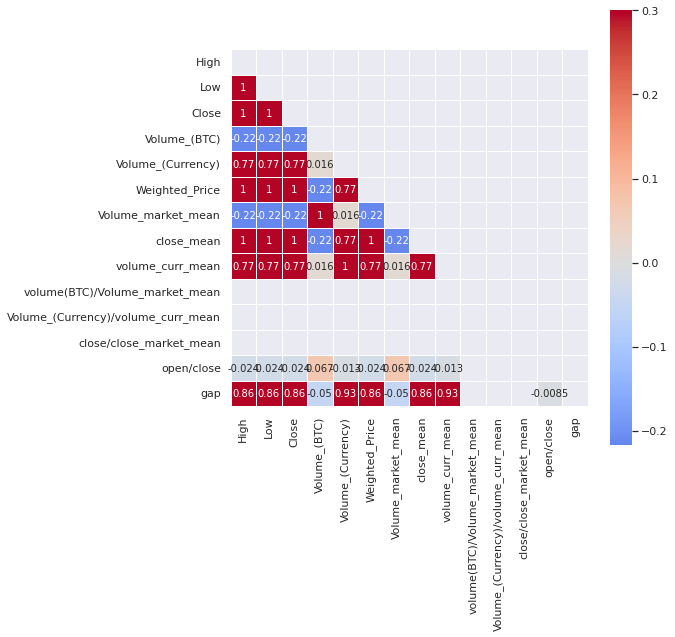

In [23]:
plt.figure(figsize=(8,8))
corr=data_df[data_df.columns[1:]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data_df[data_df.columns[1:]].corr(), mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5,annot=True)
plt.show()

In [24]:
data_df=data_df.drop(columns=['volume(BTC)/Volume_market_mean','Volume_(Currency)/volume_curr_mean','close/close_market_mean'])
data_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price', 'Volume_market_mean', 'close_mean',
       'volume_curr_mean', 'open/close', 'gap'],
      dtype='object')

<div class="alert alert-info">
    <h3><b><center>Correlation Network</center><b></h3>
</div>


In [25]:
indices = corr.index.values
cor_matrix = np.asmatrix(corr)
G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: indices[x])
#G.edges(data=True)

In [26]:
def corr_network(G, corr_direction, min_correlation):
    H = G.copy()

    for s1, s2, weight in G.edges(data=True):       
        if corr_direction == "positive":
            if weight["weight"] < 0 or weight["weight"] < min_correlation:
                H.remove_edge(s1, s2)
        else:
            if weight["weight"] >= 0 or weight["weight"] > min_correlation:
                H.remove_edge(s1, s2)
                
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    weights = tuple([(1+abs(x))**2 for x in weights])
   
    d = dict(nx.degree(H))
    nodelist=d.keys()
    node_sizes=d.values()
    
    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(9,9))

    nx.draw_networkx_nodes(H,positions,node_color='#d100d1',nodelist=nodelist,
                       node_size=tuple([x**2 for x in node_sizes]),alpha=0.8)

    nx.draw_networkx_labels(H, positions, font_size=13)

    if corr_direction == "positive":
        edge_colour = plt.cm.summer 
    else:
        edge_colour = plt.cm.autumn
        
    nx.draw_networkx_edges(H, positions, edgelist=edges,style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))
    plt.axis('off')
    plt.show() 

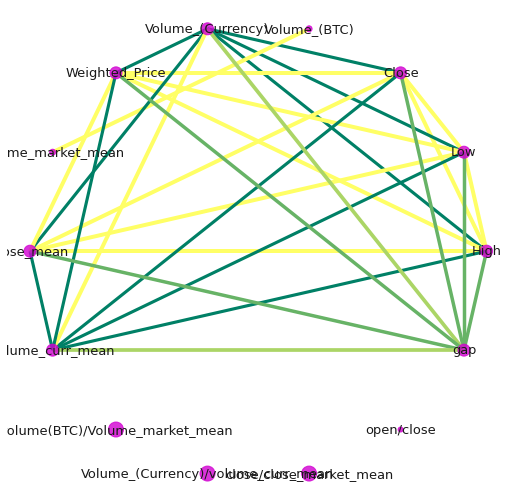

In [27]:
corr_network(G, corr_direction="positive",min_correlation = 0.5)


<a id="6"></a>
<h2 style='background-color:#87CEFA; border:0; color:black'><center>Candle stick chart on the price movements of the Bitcoin
    </center><h2>


In [28]:
data_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price', 'Volume_market_mean', 'close_mean',
       'volume_curr_mean', 'open/close', 'gap'],
      dtype='object')

In [29]:
trace1 = {
    'x': data_df.index,
    'open': data_df.Open,
    'close': data_df.Close,
    'high': data_df.High,
    'low': data_df.Low,
    'type': 'candlestick',
    'name': 'MSFT',
    'showlegend': False
}
# Calculate and define moving average of 30 periods
avg_30 = data_df.Close.rolling(window=30, min_periods=1).mean()

# Calculate and define moving average of 50 periods
avg_50 = data_df.Close.rolling(window=50, min_periods=1).mean()

trace2 = {
    'x': data_df.index,
    'y': avg_30,
    'type': 'scatter',
    'mode': 'lines',
    'line': {
        'width': 1,
        'color': 'blue'
            },
    'name': 'Moving Average of 30 periods'
}

trace3 = {
    'x': data_df.index,
    'y': avg_50,
    'type': 'scatter',
    'mode': 'lines',
    'line': {
        'width': 1,
        'color': 'red'
    },
    'name': 'Moving Average of 50 periods'
}
data_trace = [trace1, trace2, trace3]
# Config graph layout
layout = go.Layout({
    'title': {
        'text': 'Bitcoin Moving Averages',
        'font': {
            'size': 15
        } 
    }
})




fig = go.Figure(data=data_trace, layout=layout)
fig.write_html("Bitcoin Moving Averages.html")
fig.show()

In [30]:
data_df.reset_index(inplace=True)
data_df['month']=data_df['Timestamp'].dt.month
layout = go.Layout({
    'title': {
        'text': 'Bitcoin Price - Monthly',
        'font': {
            'size': 15
        } 
    }
})

fig = go.Figure(data=[go.Candlestick(x=data_df['month'],
                open=data_df['Open'], high=data_df['High'],
                low=data_df['Low'], close=data_df['Weighted_Price'])
                      ],layout=layout)
fig.show()

<a id="7"></a>
<h2 style='background-color:#87CEFA; border:0; color:black'><center>Time series Analysis and Prediction using Prophet</center><h2>



<img src="https://insightimi.files.wordpress.com/2020/07/on-de793_201909_g_20190830121038.gif" width='500' height='500'>

<div class="alert alert-warning">
    <h1><b><center>What is Prophet?</center><b></h1>
    <h3>Prophet is a facebooks’ open source time series prediction. Prophet decomposes time series into trend, seasonality and holiday. It has intuitive hyper parameters which are easy to tune.</h3>
</div>




<div class='alert alert-warning'>
    <h2><b><center>Advantages of using Prophet</center><b></h2>
        <h3> 1. Accommodates seasonality with multiple periods</h3>
        <h3> 2. Prophet is resilient to missing values</h3>
        <h3> 3. Best way to handle outliers in Prophet is to remove them</h3>
        <h3> 4. Fitting of the model is fast</h3>
    <h3> 5. Intuitive hyper parameters which are easy to tune</h3>
</div>

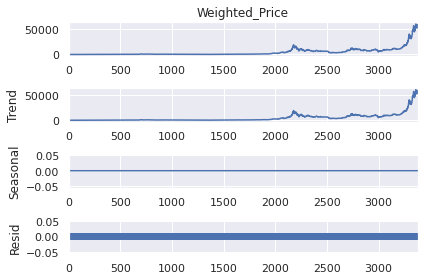

<Figure size 1080x864 with 0 Axes>

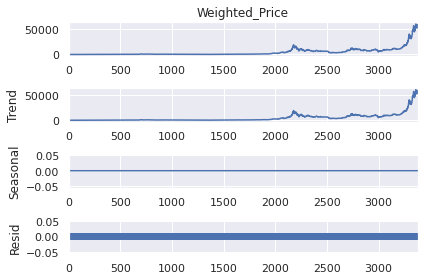

In [31]:
plt.figure(figsize=(15,12))
series = data_df.Weighted_Price
result = seasonal_decompose(series, model='additive',period=1)
result.plot()

<div class='alert alert-warning'>
    <h3><center>Input to Prophet is a data frame with minimum two columns : ds and y</center></h3>
</div>

In [32]:
# Renaming the column names accroding to Prophet's requirements
prophet_df=data_df[['Timestamp','Weighted_Price']]
prophet_df.rename(columns={'Timestamp':'ds','Weighted_Price':'y'},inplace=True)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<div class='alert alert-warning'>
    <h2><center>Creating and fitting the Prophet model with default values</center></h2>
    <h3>We will first explore the default Prophet model. Create the Prophet instance with all default values, fit the dataset.</h3>
</div>

In [33]:
prophet_basic = Prophet()
prophet_basic.fit(prophet_df[['ds','y']])

<div class='alert alert-warning'>
    <h2><center>Predicting the values for the future</center></h2>
<h4>For predicting the values using Prophet, we need to create a dataframe with ds(datetime stamp) containing the dates for which we want to make the predictions.<br><br>
We use make_future_dataframe() to which we specify the number of days to extend into the future. By default it includes dates from the history</h4>
</div>

In [34]:
future= prophet_basic.make_future_dataframe(periods=365)#Making predictions for one year
future.tail(2)

,ds
3742,2022-03-30
3743,2022-03-31


In [35]:
forecast=prophet_basic.predict(future)

<div class='alert alert-warning'>
    <h3><center>Plotting the predicted data</center></h3>
</div>

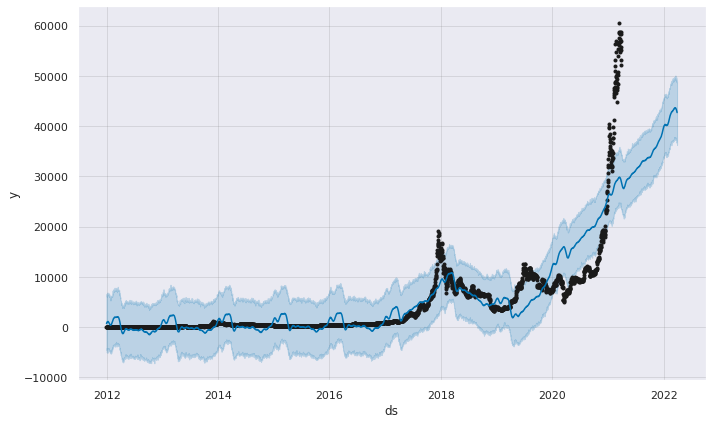

In [36]:
fig1 =prophet_basic.plot(forecast)

<div class='alert alert-warning'>
    <h3><center>Plotting the Forecasted components(Trend and Seasonality)</center></h3>
</div>

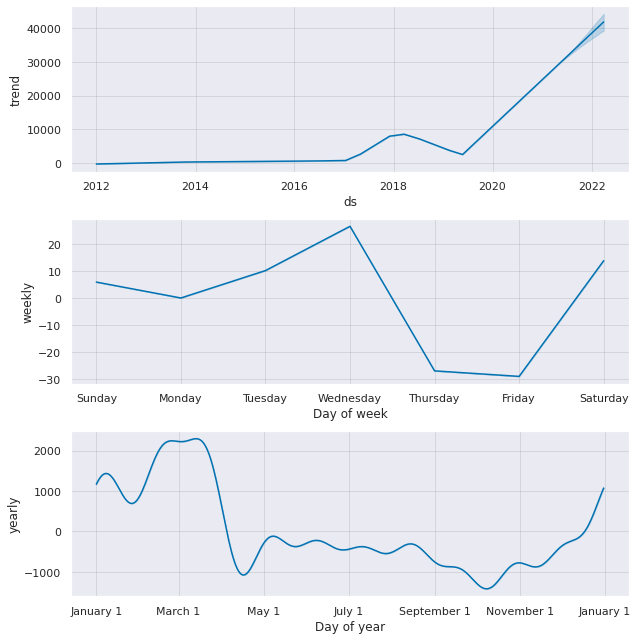

In [37]:
fig1 = prophet_basic.plot_components(forecast)

<div class='alert alert-warning'>
    <h3><center>Adding ChangePoints to Prophet</center></h3>
<h4>Changepoints are the datetime points where the time series have abrupt changes in the trajectory.<br>
By default, Prophet adds 25 changepoints to the initial 80% of the data-set.<br>
    <br><center>Let’s plot the vertical lines where the potential changepoints occurred</center><h4>
    </div>

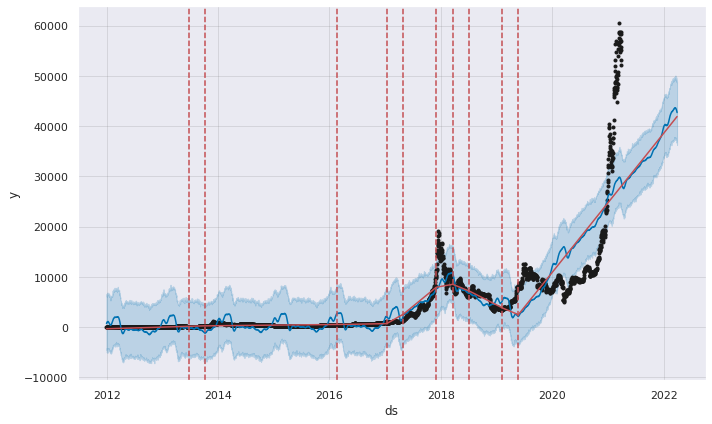

In [38]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

<div class='alert alert-warning'>
        <h3> Following are the Changepoints, where the time series had abrupt changes in the trajectory.</h3>
</div>

In [39]:
print(f'{m_}Change points:\n {y_}{prophet_basic.changepoints}\n')

Change points:
 108    2012-04-17
216    2012-08-03
324    2012-11-19
432    2013-03-07
540    2013-06-23
648    2013-10-09
757    2014-01-26
865    2014-05-14
973    2014-08-30
1081   2014-12-16
1189   2015-04-03
1297   2015-07-20
1405   2015-11-05
1513   2016-02-21
1621   2016-06-08
1729   2016-09-24
1837   2017-01-10
1945   2017-04-28
2054   2017-08-15
2162   2017-12-01
2270   2018-03-19
2378   2018-07-05
2486   2018-10-21
2594   2019-02-06
2702   2019-05-25
Name: ds, dtype: datetime64[ns]



<div class='alert alert-warning'>
    <h2><center>Adding Multiple Regressors</center></h2>
<h3>Additional regressors can be added to the Prophet model. This is done by using add_regressor. Additional regressor column value needs to be present in both the fitting as well as prediction dataframes.<h3>
    <h3><center>Creating fitting and predicting dataset with additional regressors</center></h3>
    </div>

In [40]:
data_df.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price', 'Volume_market_mean',
       'close_mean', 'volume_curr_mean', 'open/close', 'gap', 'month'],
      dtype='object')

In [41]:
prophet_df['Open'] = data_df['Open']
prophet_df['High'] = data_df['High']
prophet_df['Low'] = data_df['Low']
prophet_df['Vol(BTC)'] = data_df['Volume_(BTC)']
prophet_df['Vol(curr)'] = data_df['Volume_(Currency)']
prophet_df['Volume_market_mean'] = data_df['Volume_market_mean']
prophet_df['close_mean'] = data_df['close_mean']
prophet_df['volume_curr_mean'] = data_df['volume_curr_mean']
prophet_df['open/close'] = data_df['open/close']
prophet_df['gap'] = data_df['gap']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [42]:
pro_regressor= Prophet()
pro_regressor.add_regressor('Open')
pro_regressor.add_regressor('High')
pro_regressor.add_regressor('Low')
pro_regressor.add_regressor('Vol(BTC)')
pro_regressor.add_regressor('Vol(curr)')
pro_regressor.add_regressor('Volume_market_mean')
pro_regressor.add_regressor('close_mean')
pro_regressor.add_regressor('volume_curr_mean')
pro_regressor.add_regressor('open/close')
pro_regressor.add_regressor('gap')

train_X= prophet_df[:2500]
test_X= prophet_df[2500:]



In [43]:
#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=249)

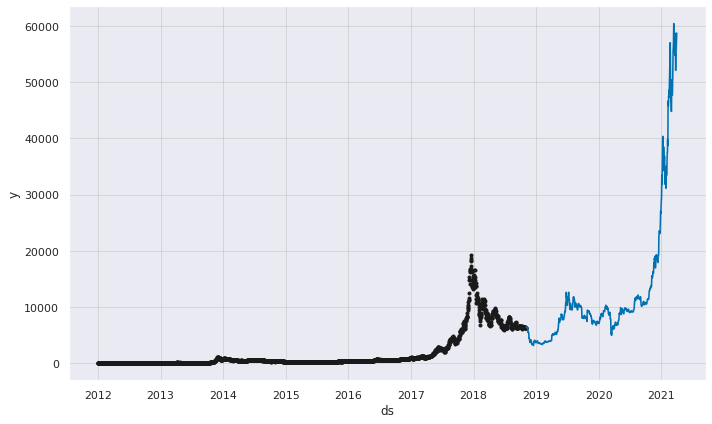

In [44]:
#Forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data);

<div class='alert alert-warning'>
<h3><center>6 different types of metrics are shown by each time horizon, but by taking moving average over 37 days in this case (can be changed by ‘rolling_window’ option).</center></h3>
</div>

  0%|          | 0/12 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.122077,0.349395,0.169986,0.001336,0.000210,0.001328,0.705479
1,38 days,0.131884,0.363158,0.177716,0.001485,0.000222,0.001475,0.695205
2,39 days,0.143722,0.379107,0.186012,0.001645,0.000243,0.001632,0.686073
3,40 days,0.158167,0.397702,0.196170,0.001815,0.000264,0.001799,0.676941
4,41 days,0.170797,0.413276,0.205247,0.001989,0.000289,0.001970,0.667808


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
324,361 days,2.925893,1.710524,1.134038,0.004180,0.001694,0.004174,0.873288
325,362 days,2.930562,1.711889,1.136142,0.004170,0.000461,0.004164,0.873288
326,363 days,2.935809,1.713420,1.137930,0.004163,0.001515,0.004157,0.873288
327,364 days,2.941328,1.715030,1.139807,0.004154,0.001515,0.004149,0.873288
328,365 days,2.946653,1.716582,1.141764,0.004145,0.001411,0.004140,0.873288


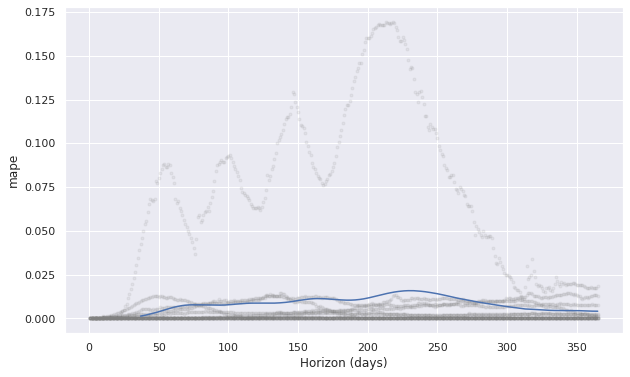

In [45]:
df_cv = cross_validation(pro_regressor, initial='100 days', period='180 days', horizon = '365 days')
pm = performance_metrics(df_cv, rolling_window=0.1)
display(pm.head(),pm.tail())
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.1)
plt.show()

<div class='alert alert-info'>
    <h3><center>MAPE</center></h3>
    <p>The MAPE (Mean Absolute Percent Error) measures the size of the error in percentage terms. It is calculated as the average of the unsigned percentage error</p>
    <p>Many organizations focus primarily on the MAPE when assessing forecast accuracy. Most people are comfortable thinking in percentage terms, making the MAPE easy to interpret. It can also convey information when you don’t know the item’s demand volume. For example, telling your manager, "we were off by less than 4%" is more meaningful than saying "we were off by 3,000 cases," if your manager doesn’t know an item’s typical demand volume.<p>
    <img src="https://www.forecastpro.com/Trends/images/MAPE1.jpg" width='500'>
</div>

<div class='alert alert-warning'>
    <h3><center>What Prophet doesnt do</center></h3>
    <h4><b>1.Prophet does not allow non-Gaussian noise distribution:<b></h4> 
<p>In Prophet, noise distribution is always Gaussian and pre-transformation of y values is the only way to handle the values following skewed distribution.</p>
        <h4><b>2. Prophet does not take autocorrelation on residual into account</b></h4>
<p>Since epsilon noise portion in the formula assume i.i.d. normal distribution, the residual is not assumed to have autocorrelation, unlike ARIMA model.</p>
        <h4><b>3. Prophet does not assume stochastic trend</b></h4>
<p>Prophet’s trend component is always deterministic+possible changepoints and it won’t assume stochastic trend unlike ARIMA.</p>
</div>

<a id="8"></a>
<h2 style='background-color:#87CEFA; border:0; color:black'><center>Prediction using Pycaret</center><h2>



In [46]:
!pip install pycaret==2.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.6/261.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.4 MB/s

<div class='alert alert-warning'>
    <h3><center> PyCaret’s Regression Module</center></h3><br>
    <h4>PyCaret’s Regression Module is a supervised machine learning module that is used for estimating the relationships between a dependent variable (often called the ‘outcome variable’, or ‘target’) and one or more independent variables (often called ‘features’, ‘predictors’, or ‘covariates’).<br><br> The objective of regression is to predict continuous values such as predicting sales amount, predicting quantity, predicting temperature, etc. This module provides several pre-processing features that prepare the data for modeling through the setup function. It has over 25 ready-to-use algorithms and several plots to analyze the performance of trained models.</h4>
</div>

In [47]:
data_df.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price', 'Volume_market_mean',
       'close_mean', 'volume_curr_mean', 'open/close', 'gap', 'month'],
      dtype='object')

In [48]:
data_df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Volume_market_mean,close_mean,volume_curr_mean,open/close,gap,month
0,2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330086,4.471603,23.829470,4.482500,106.330086,0.996096,0.017500,12
1,2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667,7.200667,4.806667,35.259720,1.000000,0.000000,1
2,2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.239998,5.000000,19.048000,5.000000,95.239998,1.000000,0.000000,1
3,2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500,11.004660,5.252500,58.100651,1.000000,0.000000,1
4,2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914806,63.119579,5.208159,11.914806,5.223333,63.119579,0.995533,0.023333,1


In [49]:
%%time
from pycaret.regression import *
data_df.set_index('Timestamp',inplace=True)
exp_name = setup(data=data_df,target="Weighted_Price",silent=True)
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,308.4126,1176670.6756,994.1845,0.9820,0.5639,0.7851,1.7800
lightgbm,Light Gradient Boosting Machine,399.1815,1923759.7688,1296.5078,0.9713,0.5644,0.8862,0.1570
et,Extra Trees Regressor,379.5941,2028884.1133,1315.4984,0.9684,0.1689,0.1104,0.4400
gbr,Gradient Boosting Regressor,619.2325,2456973.3543,1509.7788,0.9611,0.8125,1.6615,0.1530
rf,Random Forest Regressor,433.0774,2502565.6405,1494.8379,0.9607,0.2150,0.2770,0.6330
xgboost,Extreme Gradient Boosting,413.0986,2666020.4594,1511.9721,0.9574,0.3625,0.3266,0.3060
dt,Decision Tree Regressor,592.7231,4648291.4083,2037.7804,0.9223,0.2098,0.1318,0.0270
ada,AdaBoost Regressor,2015.2290,7670890.2348,2731.4415,0.8807,2.1507,30.8555,0.0730
br,Bayesian Ridge,2245.7091,15444909.2395,3855.6540,0.7604,2.0648,25.8590,0.0150
ridge,Ridge Regression,2257.3917,15434990.7000,3854.5723,0.7603,2.0677,26.2338,0.0130


CPU times: user 15 s, sys: 1.44 s, total: 16.4 s
Wall time: 54.1 s
